## Imports

In [1]:
import sys
sys.path.append("..")

In [3]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import when, col, count, upper
from datetime import date
from helpers import SnowflakeHelper
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
snowflake_helper = SnowflakeHelper()
snowflake_config = './../helpers/snowflake_config.json'
session = snowflake_helper.create_snowpark_session(snowflake_config)

[INFO] No schema passed, using default schema SAFEGUARDING_NYC_SCHEMA_BRONZE for the session
[SUCCESS] Config file loaded successfully!
[SUCCESS] Snowspark Session created successfully on schema SAFEGUARDING_NYC_SCHEMA_BRONZE!


## Extracting Data

In [5]:
use_of_force_combined = session.table('SAFEGUARDING_NYC_SCHEMA_GOLD.use_of_force_combined')

In [6]:
use_of_force_combined.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"FORCETYPE"        |"INCIDENT PCT"  |"TRI INCIDENT NUMBER"  |"PATROL BOROUGH"  |"OCCURRENCE DATE"  |"FORCE AGAINST MOS"  |"AGE"  |"SUBJECT GENDER"  |"SUBJECT RACE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
|Physical Force     |1               |2020020962067          |MANHATTAN         |2020-05-06         |Physical Force       |NULL   |MALE              |BLACK           |
|Physical Force     |1               |2020020962143          |MANHATTAN         |2020-10-11         |Physical Force       |NULL   |MALE              |BLACK           |
|Physical Force     |5               |2020024962080          |MANHATTAN         |2020-06-30         |Physical Force       |NULL   |MALE              |BLACK     

In [7]:
data = use_of_force_combined.collect()

In [8]:
use_of_force_combined_pandas_df = pd.DataFrame(data, columns=[col.name for col in use_of_force_combined.schema.fields])

In [9]:
use_of_force_combined_pandas_df.head()

,FORCETYPE,"""INCIDENT PCT""","""TRI INCIDENT NUMBER""","""PATROL BOROUGH""","""OCCURRENCE DATE""","""FORCE AGAINST MOS""",AGE,"""SUBJECT GENDER""","""SUBJECT RACE"""
0,Physical Force,1,2020020962067,MANHATTAN,2020-05-06,Physical Force,None,MALE,BLACK
1,Physical Force,1,2020020962143,MANHATTAN,2020-10-11,Physical Force,None,MALE,BLACK
2,Physical Force,5,2020024962080,MANHATTAN,2020-06-30,Physical Force,None,MALE,BLACK
3,Electrical Weapon,6,2020025962038,MANHATTAN,2020-03-02,Physical Force,None,MALE,BLACK
4,Physical Force,6,2020025962049,MANHATTAN,2020-03-25,Physical Force,None,MALE,BLACK


## EDA

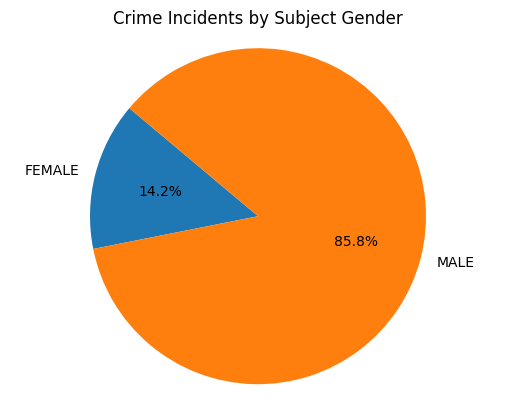

In [10]:
gender_data = use_of_force_combined_pandas_df.groupby('"SUBJECT GENDER"').size()

# Plot
gender_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Crime Incidents by Subject Gender')
plt.show()

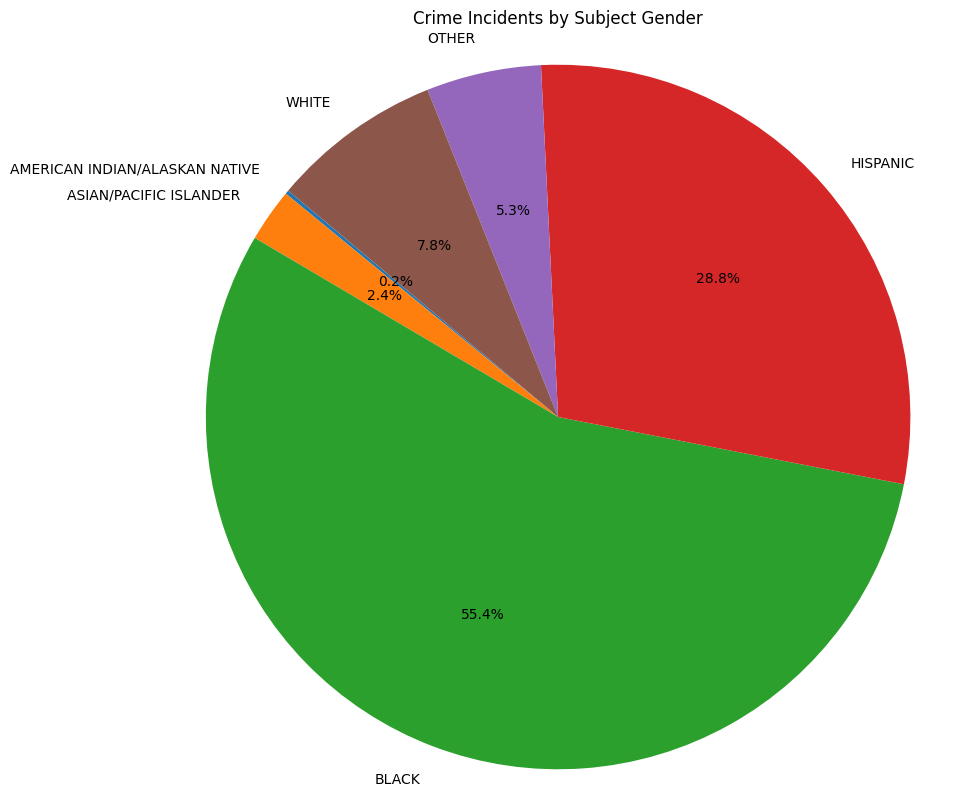

In [11]:
gender_data = use_of_force_combined_pandas_df.groupby('"SUBJECT RACE"').size()

# Plot
plt.figure(figsize=(10, 10))  # Adjust the numbers (width, height) as needed

# Plot the pie chart
gender_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Crime Incidents by Subject Gender')

# Show the larger pie chart
plt.show()

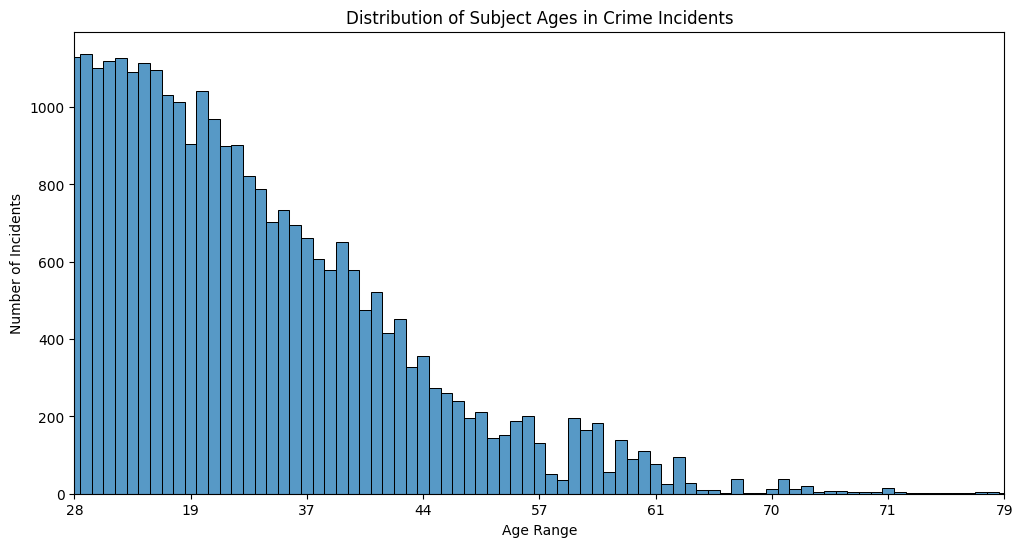

In [12]:
bins = range(0, 81, 10)  # Adjust the range and bin size as needed

plt.figure(figsize=(12, 6))
sns.histplot(use_of_force_combined_pandas_df['AGE'], bins=bins, kde=False)
plt.title('Distribution of Subject Ages in Crime Incidents')
plt.xlabel('Age Range')
plt.ylabel('Number of Incidents')

# Customize x-axis tick labels
plt.xticks(bins)  # Set x-axis ticks to the bin values
plt.xlim(0, 80)  # Adjust the x-axis limits if needed

plt.show()

In [13]:
use_of_force_combined_pandas_df['"OCCURRENCE DATE"'] = pd.to_datetime(use_of_force_combined_pandas_df['"OCCURRENCE DATE"'])

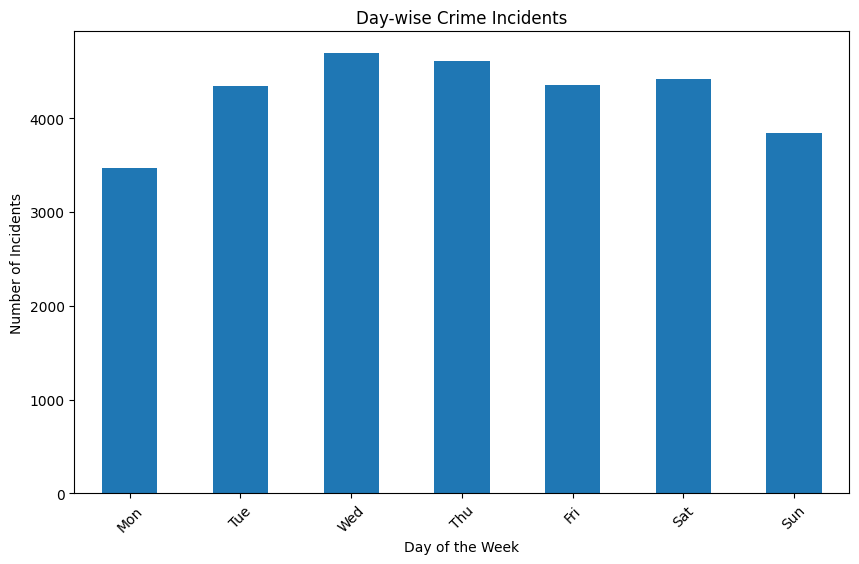

In [14]:
daywise_data=use_of_force_combined_pandas_df['"OCCURRENCE DATE"'].dt.dayofweek.groupby(use_of_force_combined_pandas_df['"OCCURRENCE DATE"'].dt.dayofweek).size()

# Plot
plt.figure(figsize=(10, 6))
daywise_data.plot(kind='bar')
plt.title('Day-wise Crime Incidents')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Incidents')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
plt.show()

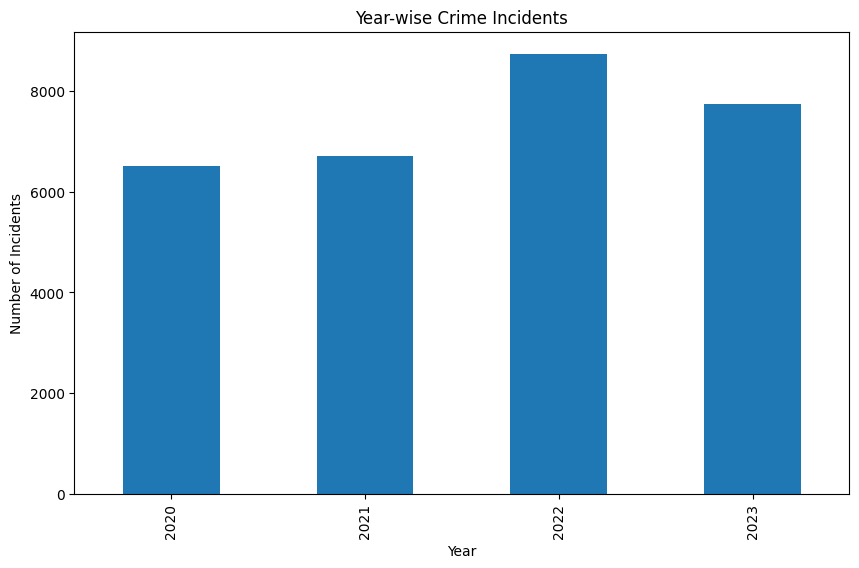

In [15]:
yearly_data=use_of_force_combined_pandas_df['"OCCURRENCE DATE"'].dt.year.groupby(use_of_force_combined_pandas_df['"OCCURRENCE DATE"'].dt.year).size()

# Plot
plt.figure(figsize=(10, 6))
yearly_data.plot(kind='bar')
plt.title('Year-wise Crime Incidents')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

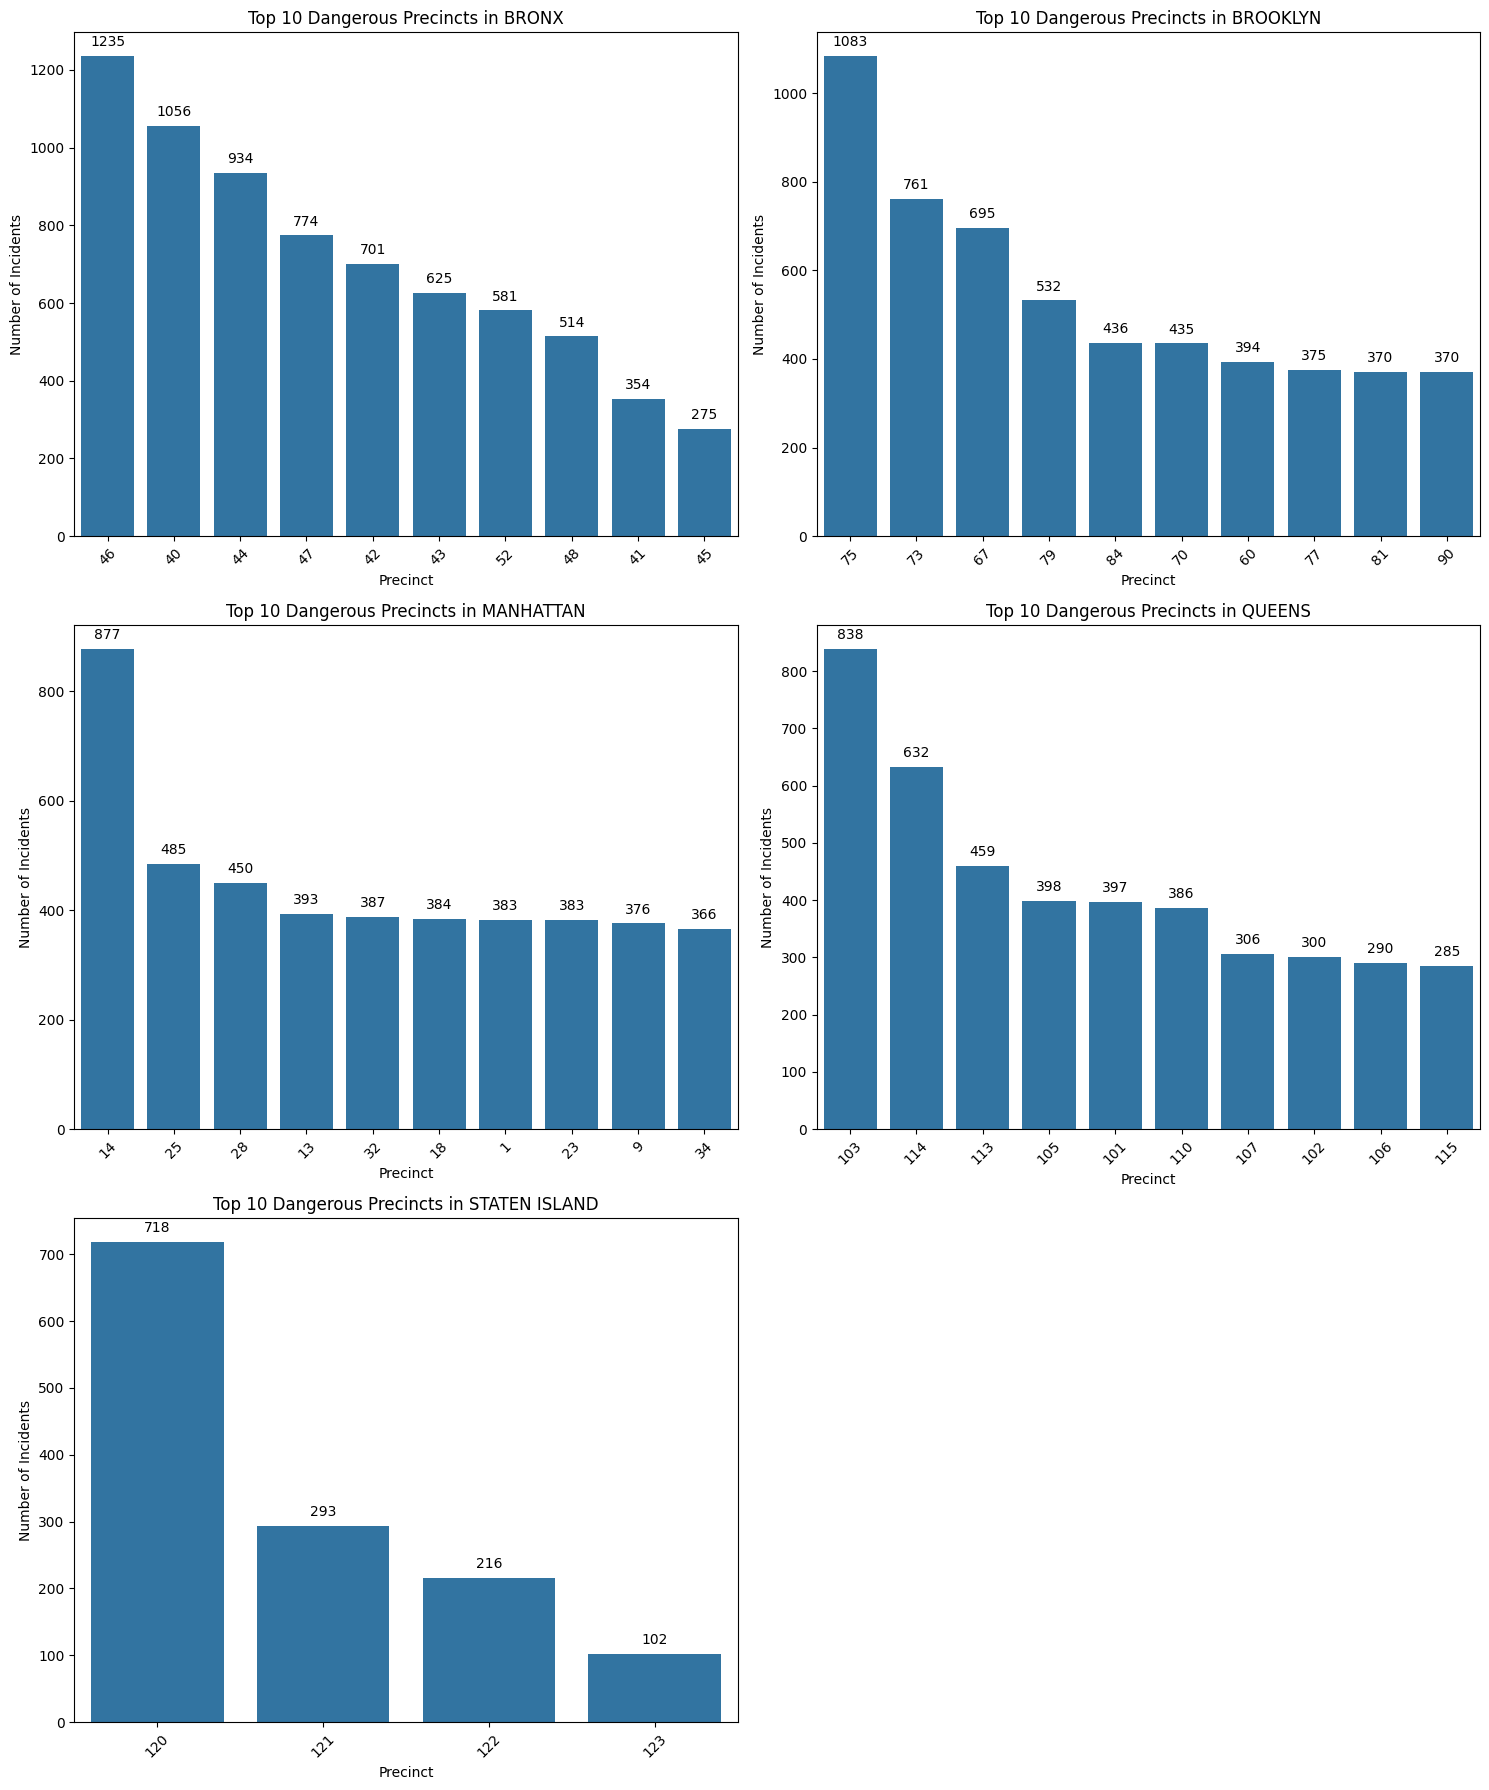

In [16]:
borough_precinct_data = use_of_force_combined_pandas_df.groupby(['"PATROL BOROUGH"', '"INCIDENT PCT"']).size().reset_index(name='counts')

# Get top 10 precincts for each borough
top_precincts = borough_precinct_data.groupby('"PATROL BOROUGH"').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)

# Convert 'Incident Pct' to a string
top_precincts['"INCIDENT PCT"'] = top_precincts['"INCIDENT PCT"'].astype(str)

# Unique list of boroughs
boroughs = top_precincts['"PATROL BOROUGH"'].unique()

# Determine the number of rows and columns needed for the subplots
num_rows = len(boroughs) // 2 + len(boroughs) % 2  # Add 1 if there's an odd number of boroughs
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
axes = axes.flatten()  # Flatten the array for easy iteration

# Plot for each borough
for i, borough in enumerate(boroughs):
    borough_data = top_precincts[top_precincts['"PATROL BOROUGH"'] == borough]
    
    # Check if the current index exceeds the number of available axes
    if i < len(axes):
        ax = sns.barplot(data=borough_data, x='"INCIDENT PCT"', y='counts', ax=axes[i])
        axes[i].set_title(f'Top 10 Dangerous Precincts in {borough}')
        axes[i].set_xlabel('Precinct')
        axes[i].set_ylabel('Number of Incidents')
        axes[i].tick_params(axis='x', rotation=45)

        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Remove any empty subplots
for j in range(len(boroughs), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

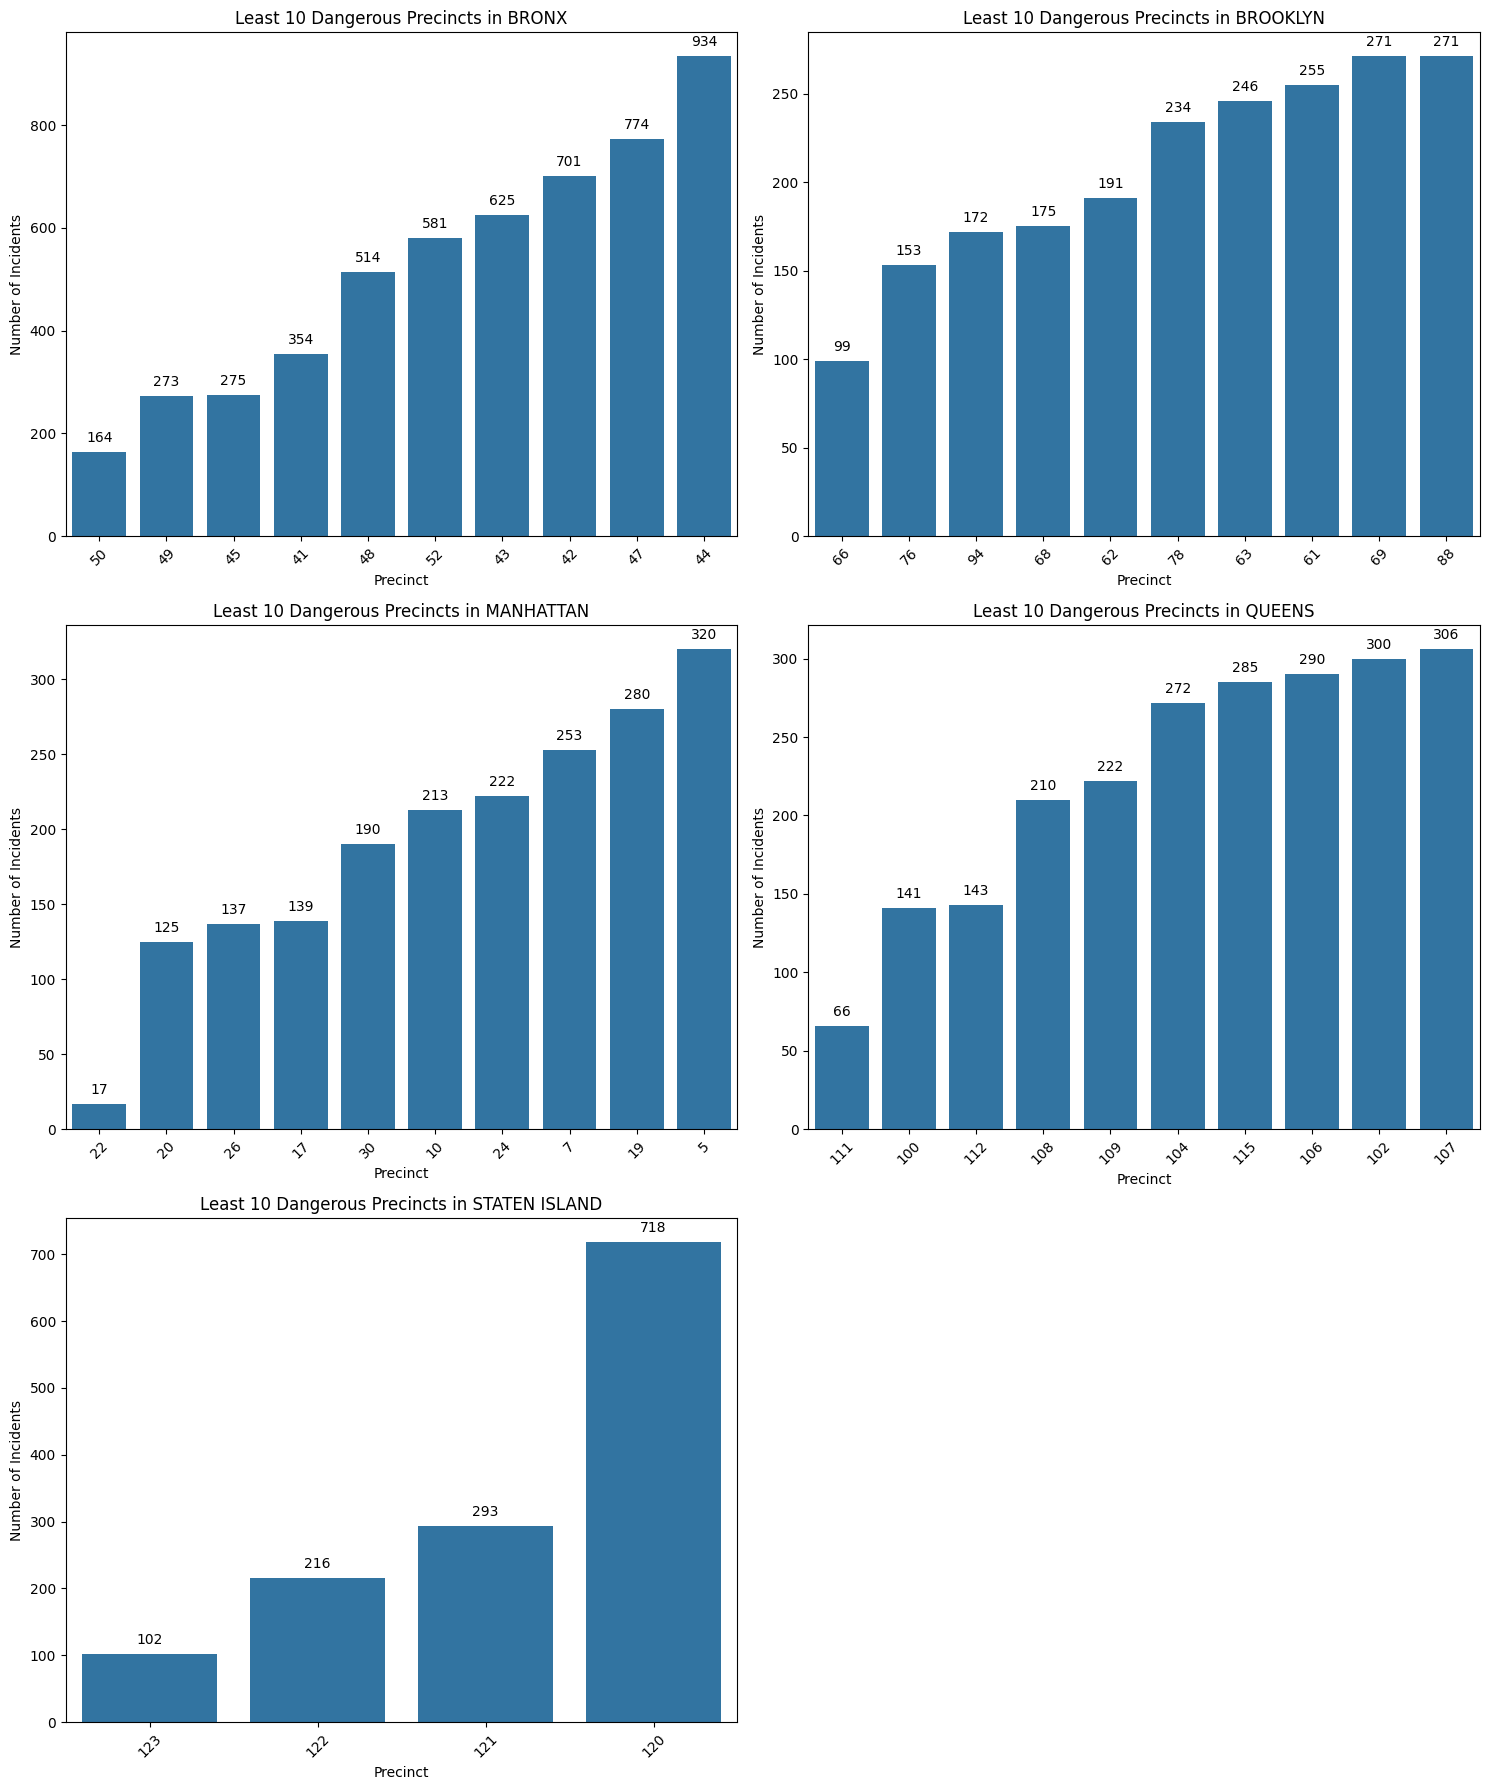

In [17]:
borough_precinct_data = use_of_force_combined_pandas_df.groupby(['"PATROL BOROUGH"', '"INCIDENT PCT"']).size().reset_index(name='counts')

# Get least 10 precincts for each borough
least_precincts = borough_precinct_data.groupby('"PATROL BOROUGH"').apply(lambda x: x.nsmallest(10, 'counts')).reset_index(drop=True)

# Convert 'Incident Pct' to a string
least_precincts['"INCIDENT PCT"'] = least_precincts['"INCIDENT PCT"'].astype(str)

# Unique list of boroughs
boroughs = least_precincts['"PATROL BOROUGH"'].unique()

# Determine the number of rows and columns needed for the subplots
num_rows = len(boroughs) // 2 + len(boroughs) % 2  # Add 1 if there's an odd number of boroughs
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
axes = axes.flatten()  # Flatten the array for easy iteration

# Plot for each borough
for i, borough in enumerate(boroughs):
    borough_data = least_precincts[least_precincts['"PATROL BOROUGH"'] == borough]
    
    # Check if the current index exceeds the number of available axes
    if i < len(axes):
        ax = sns.barplot(data=borough_data, x='"INCIDENT PCT"', y='counts', ax=axes[i])
        axes[i].set_title(f'Least 10 Dangerous Precincts in {borough}')
        axes[i].set_xlabel('Precinct')
        axes[i].set_ylabel('Number of Incidents')
        axes[i].tick_params(axis='x', rotation=45)

        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Remove any empty subplots
for j in range(len(boroughs), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

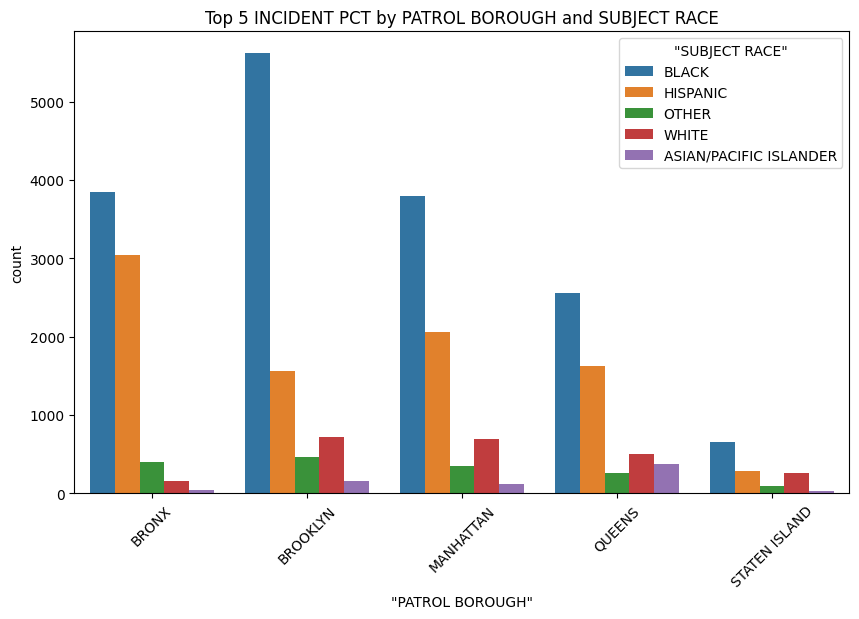

In [18]:
grouped_df = use_of_force_combined_pandas_df.groupby(['"PATROL BOROUGH"', '"SUBJECT RACE"'])['"INCIDENT PCT"'].count().reset_index(name='count')

# Sort and select top 5 'INCIDENT PCT' for each 'PATROL BOROUGH'
top_incidents = grouped_df.sort_values(['"PATROL BOROUGH"', 'count'], ascending=[True, False]).groupby('"PATROL BOROUGH"').head(5)

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x='"PATROL BOROUGH"', y='count', hue='"SUBJECT RACE"', data=top_incidents)
plt.title('Top 5 INCIDENT PCT by PATROL BOROUGH and SUBJECT RACE')
plt.xticks(rotation=45)
plt.show()